In [1]:
import datetime
import math
import os
from os import path
from pathlib import Path
import sys
from tqdm import tqdm

import random

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import torch.distributed as distributed

distributed.init_process_group(
    backend="nccl", init_method="tcp://localhost:25763", rank=0, world_size=1
)
print(f"CUDA Device count: {torch.cuda.device_count()}")

local_rank = torch.distributed.get_rank()
world_size = torch.distributed.get_world_size()
torch.cuda.set_device(local_rank)

print(f"I am rank {local_rank} in this world of size {world_size}!")

CUDA Device count: 1
I am rank 0 in this world of size 1!


In [3]:
XMem_path = os.path.abspath("../../../external/XMem")  # Parent folder /app/mount
sys.path.append(XMem_path)
# !wget -P ./saves/ https://github.com/hkchengrex/XMem/releases/download/v1.0/XMem.pth

In [4]:
from util.logger import TensorboardLogger

from model.trainer import XMemTrainer

In [5]:
torch.backends.cudnn.benchmark = True

In [6]:
im_mean = (124, 116, 104)

im_normalization = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

inv_im_trans = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
)

In [7]:
def reseed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

In [8]:
def plotDatasetSample(dataset, rows):
    first_seq = dataset[0]
    print("rgb", first_seq["rgb"].shape)
    print("first_frame_gt", first_seq["first_frame_gt"].shape)
    print("cls_gt", first_seq["cls_gt"].shape)
    print("selector", first_seq["selector"])
    print("info", first_seq["info"])

    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(10, 15))

    for i in range(rows):
        # Plot RGB image
        rgb_image = inv_im_trans(first_seq["rgb"][i]).permute(1, 2, 0).numpy()
        axes[i, 0].imshow(rgb_image)
        axes[i, 0].axis("off")

        # Plot binary mask
        mask = first_seq["cls_gt"][i][0]
        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

In [9]:
class InstrumentDataset(Dataset):
    """
    Works for DAVIS/YouTubeVOS/BL30K training
    For each sequence:
    - Pick three frames
    - Pick two objects
    - Apply some random transforms that are the same for all frames
    - Apply random transform to each of the frame
    - The distance between frames is controlled
    """

    def __init__(
        self,
        im_root,
        gt_root,
        max_jump,
        subset=None,
        num_frames=3,
        max_num_obj=1,
        finetune=False,
    ):

        self.im_root = im_root  # Root directory for Images
        self.gt_root = gt_root  # Root directory for ground truth data
        self.max_jump = max_jump  # Maximum distance between frames
        # self.is_bl = is_bl # Is it a blender dataset
        self.num_frames = num_frames  # Number of frames to be sampled
        self.max_num_obj = max_num_obj  # Maximum number of objects

        # Initialize lists for storing video and frame information
        self.videos = []  # List of videos
        self.frames = {}  # Dictionary mapping video to its frames

        vid_list = sorted(os.listdir(self.im_root))
        # Pre-filtering
        for vid in vid_list:
            # If looking for a subset of videos only
            if subset is not None:
                vid_name = vid
                if vid_name not in subset:
                    continue

            # List frames in each video directory
            frames = sorted(os.listdir(os.path.join(self.im_root, vid)))

            if len(frames) < num_frames:
                continue
            self.frames[vid] = frames
            self.videos.append(vid)

        print(
            "%d out of %d videos accepted in %s."
            % (len(self.videos), len(vid_list), im_root)
        )

        # These set of transform is the same for im/gt pairs, but different among the 3 sampled frames
        self.pair_im_lone_transform = transforms.Compose(
            [
                transforms.ColorJitter(0.01, 0.01, 0.01, 0),
            ]
        )

        self.pair_im_dual_transform = transforms.Compose(
            [
                transforms.RandomAffine(
                    degrees=0 if finetune else 15,
                    shear=0 if finetune else 10,
                    interpolation=InterpolationMode.BILINEAR,
                    fill=im_mean,
                ),
            ]
        )

        self.pair_gt_dual_transform = transforms.Compose(
            [
                transforms.RandomAffine(
                    degrees=0 if finetune else 15,
                    shear=0 if finetune else 10,
                    interpolation=InterpolationMode.NEAREST,
                    fill=0,
                ),
            ]
        )

        # These transform are the same for all pairs in the sampled sequence
        self.all_im_lone_transform = transforms.Compose(
            [
                transforms.ColorJitter(0.1, 0.03, 0.03, 0),
                transforms.RandomGrayscale(0.05),
            ]
        )

        self.all_im_dual_transform = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(
                    (384, 384),
                    scale=(0.36, 1.00),
                    interpolation=InterpolationMode.BILINEAR,
                ),
            ]
        )

        self.all_gt_dual_transform = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(
                    (384, 384),
                    scale=(0.36, 1.00),
                    interpolation=InterpolationMode.NEAREST,
                ),
            ]
        )

        # Final transform without randomness
        self.final_im_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                im_normalization,
            ]
        )

    def __getitem__(self, idx):
        video = self.videos[idx]
        info = {}
        info["name"] = video

        vid_im_path = path.join(self.im_root, video)
        vid_gt_path = path.join(self.gt_root, video)
        frames = self.frames[video]

        trials = 0
        while trials < 5:
            info["frames"] = []  # Appended with actual frames

            num_frames = self.num_frames
            length = len(frames)
            this_max_jump = min(len(frames), self.max_jump)

            # iterative sampling
            frames_idx = [np.random.randint(length)]
            acceptable_set = set(
                range(
                    max(0, frames_idx[-1] - this_max_jump),
                    min(length, frames_idx[-1] + this_max_jump + 1),
                )
            ).difference(set(frames_idx))
            while len(frames_idx) < num_frames:
                idx = np.random.choice(list(acceptable_set))
                frames_idx.append(idx)
                new_set = set(
                    range(
                        max(0, frames_idx[-1] - this_max_jump),
                        min(length, frames_idx[-1] + this_max_jump + 1),
                    )
                )
                acceptable_set = acceptable_set.union(new_set).difference(
                    set(frames_idx)
                )

            frames_idx = sorted(frames_idx)
            if np.random.rand() < 0.5:
                # Reverse time
                frames_idx = frames_idx[::-1]

            sequence_seed = np.random.randint(2147483647)
            images = []
            masks = []
            target_objects = []
            for f_idx in frames_idx:
                jpg_name = frames[f_idx]
                png_name = frames[f_idx]
                info["frames"].append(jpg_name)

                reseed(sequence_seed)
                this_im = Image.open(path.join(vid_im_path, jpg_name)).convert("RGB")
                this_im = self.all_im_dual_transform(this_im)
                this_im = self.all_im_lone_transform(this_im)
                reseed(sequence_seed)
                this_gt = Image.open(path.join(vid_gt_path, png_name)).convert("P")
                this_gt = self.all_gt_dual_transform(this_gt)

                pairwise_seed = np.random.randint(2147483647)
                reseed(pairwise_seed)
                this_im = self.pair_im_dual_transform(this_im)
                this_im = self.pair_im_lone_transform(this_im)
                reseed(pairwise_seed)
                this_gt = self.pair_gt_dual_transform(this_gt)

                this_im = self.final_im_transform(this_im)
                this_gt = np.array(this_gt)

                images.append(this_im)
                masks.append(this_gt)

            images = torch.stack(images, 0)

            labels = np.unique(masks[0])
            # Remove background
            labels = labels[labels != 0]

            if len(labels) == 0:
                target_objects = []
                trials += 1
            else:
                target_objects = labels.tolist()
                break

        if len(target_objects) > self.max_num_obj:
            target_objects = np.random.choice(
                target_objects, size=self.max_num_obj, replace=False
            )

        info["num_objects"] = max(1, len(target_objects))

        masks = np.stack(masks, 0)

        # Generate one-hot ground-truth
        cls_gt = np.zeros((self.num_frames, 384, 384), dtype=np.int64)
        first_frame_gt = np.zeros((1, self.max_num_obj, 384, 384), dtype=np.int64)
        for i, l in enumerate(target_objects):
            this_mask = masks == l
            cls_gt[this_mask] = i + 1
            first_frame_gt[0, i] = this_mask[0]
        cls_gt = np.expand_dims(cls_gt, 1)

        # 1 if object exist, 0 otherwise
        selector = [
            1 if i < info["num_objects"] else 0 for i in range(self.max_num_obj)
        ]
        selector = torch.FloatTensor(selector)

        data = {
            "rgb": images,
            "first_frame_gt": first_frame_gt,
            "cls_gt": cls_gt,
            "selector": selector,
            "info": info,
        }

        return data

    def __len__(self):
        return len(self.videos)

In [10]:
raw_config = {
    "benchmark": False,
    "bl_root": "../BL30K",
    "davis_root": "../DAVIS",
    "debug": False,
    "deep_update_prob": 0.2,
    "exp_id": "NULL",
    "gamma": 0.1,
    "hidden_dim": 64,
    "key_dim": 64,
    "load_checkpoint": None,
    "load_network": None,
    "log_image_interval": 100,
    "log_text_interval": 100,
    "no_amp": False,
    "num_workers": 8,
    "s3_batch_size": 2,
    "s3_end_warm": 2100,
    "s3_finetune": 0,
    "s3_iterations": 10_000,
    "s3_lr": 1e-5,
    "s3_num_frames": 8,
    "s3_num_ref_frames": 3,
    "s3_start_warm": 600,
    "s3_steps": [8000],
    "save_checkpoint_interval": 100,
    "save_network_interval": 100,
    "stages": "3",
    "static_root": "../static",
    "value_dim": 512,
    "weight_decay": 0.05,
    "yv_root": "../YouTube",
}

In [11]:
# Set seed to ensure the same initialization
torch.manual_seed(14159265)
np.random.seed(14159265)
random.seed(14159265)

stage = "s" + raw_config["stages"] if len(raw_config["stages"]) == 1 else 3


config = {
    "batch_size": raw_config[stage + "_batch_size"],
    "iterations": raw_config[stage + "_iterations"],
    "finetune": raw_config[stage + "_finetune"],
    "steps": raw_config[stage + "_steps"],
    "lr": raw_config[stage + "_lr"],
    "num_ref_frames": raw_config[stage + "_num_ref_frames"],
    "num_frames": raw_config[stage + "_num_frames"],
    "start_warm": raw_config[stage + "_start_warm"],
    "end_warm": raw_config[stage + "_end_warm"],
}

config["num_workers"] = raw_config["num_workers"]

config["deep_update_prob"] = raw_config["deep_update_prob"]
config["weight_decay"] = raw_config["weight_decay"]
config["gamma"] = raw_config["gamma"]
config["amp"] = not raw_config["no_amp"]

config["log_text_interval"] = raw_config["log_text_interval"]
config["log_image_interval"] = raw_config["log_image_interval"]
config["save_network_interval"] = raw_config["save_network_interval"]
config["save_checkpoint_interval"] = raw_config["save_checkpoint_interval"]

config["debug"] = raw_config["debug"]
config["exp_id"] = "EndoVis18_MultiClass"

long_id = "%s_%s" % (
    datetime.datetime.now().strftime("%b%d_%H.%M.%S"),
    config["exp_id"],
)

git_info = "XMem"
logger = TensorboardLogger(config["exp_id"], long_id, git_info)
logger.log_string("hyperpara", str(config))

git XMem
hyperpara {'batch_size': 2, 'iterations': 10000, 'finetune': 0, 'steps': [8000], 'lr': 1e-05, 'num_ref_frames': 3, 'num_frames': 8, 'start_warm': 600, 'end_warm': 2100, 'num_workers': 8, 'deep_update_prob': 0.2, 'weight_decay': 0.05, 'gamma': 0.1, 'amp': True, 'log_text_interval': 100, 'log_image_interval': 100, 'save_network_interval': 100, 'save_checkpoint_interval': 100, 'debug': False, 'exp_id': 'EndoVis18_MultiClass'}


In [12]:
model = XMemTrainer(
    config,
    logger=logger,
    save_path=path.join("saves", long_id, long_id) if long_id is not None else None,
    local_rank=0,
    world_size=1,
).train()
model.load_network("../../../external/XMem/saves/XMem.pth")

total_iter = 0

key_dim not found in config. Set to default 64
value_dim not found in config. Set to default 512
hidden_dim not found in config. Set to default 64
Single object mode: False


model_size 62185224


/home/nikhilhenry/projects/surgical_clean/SurgicalAI/external/XMem/model/trainer.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/home/nikhilhenry/projects/surgical_clean/SurgicalAI/external/XMem/model/trainer.py:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_sa

Network weight loaded from memory.
Network weight loaded from ../../../external/XMem/saves/XMem.pth


In [13]:
def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % (2**31) + worker_id + local_rank * 100
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [14]:
def renew_loader(
    video_path, masks_path, max_skip, subset=None, finetune=True, max_num_obj=5
):
    dataset = InstrumentDataset(
        video_path,
        masks_path,
        max_jump=max_skip,
        subset=subset,
        num_frames=config["num_frames"],
        max_num_obj=max_num_obj,
        finetune=finetune,
    )

    train_sampler = torch.utils.data.distributed.DistributedSampler(
        dataset, rank=local_rank, shuffle=True
    )
    train_loader = DataLoader(
        dataset,
        config["batch_size"],
        sampler=train_sampler,
        num_workers=config["num_workers"],
        worker_init_fn=worker_init_fn,
        drop_last=True,
    )

    return train_sampler, train_loader

### Training on EndoVis 18 Data

8 out of 8 videos accepted in ../../../data/endovis/endo17/data/frames/endo17_train_frames.


rgb torch.Size([8, 3, 384, 384])
first_frame_gt (1, 5, 384, 384)
cls_gt (8, 1, 384, 384)
selector tensor([1., 0., 0., 0., 0.])
info {'name': 'instrument_dataset_01', 'frames': ['frame209.png', 'frame207.png', 'frame203.png', 'frame201.png', 'frame198.png', 'frame197.png', 'frame192.png', 'frame189.png'], 'num_objects': 1}


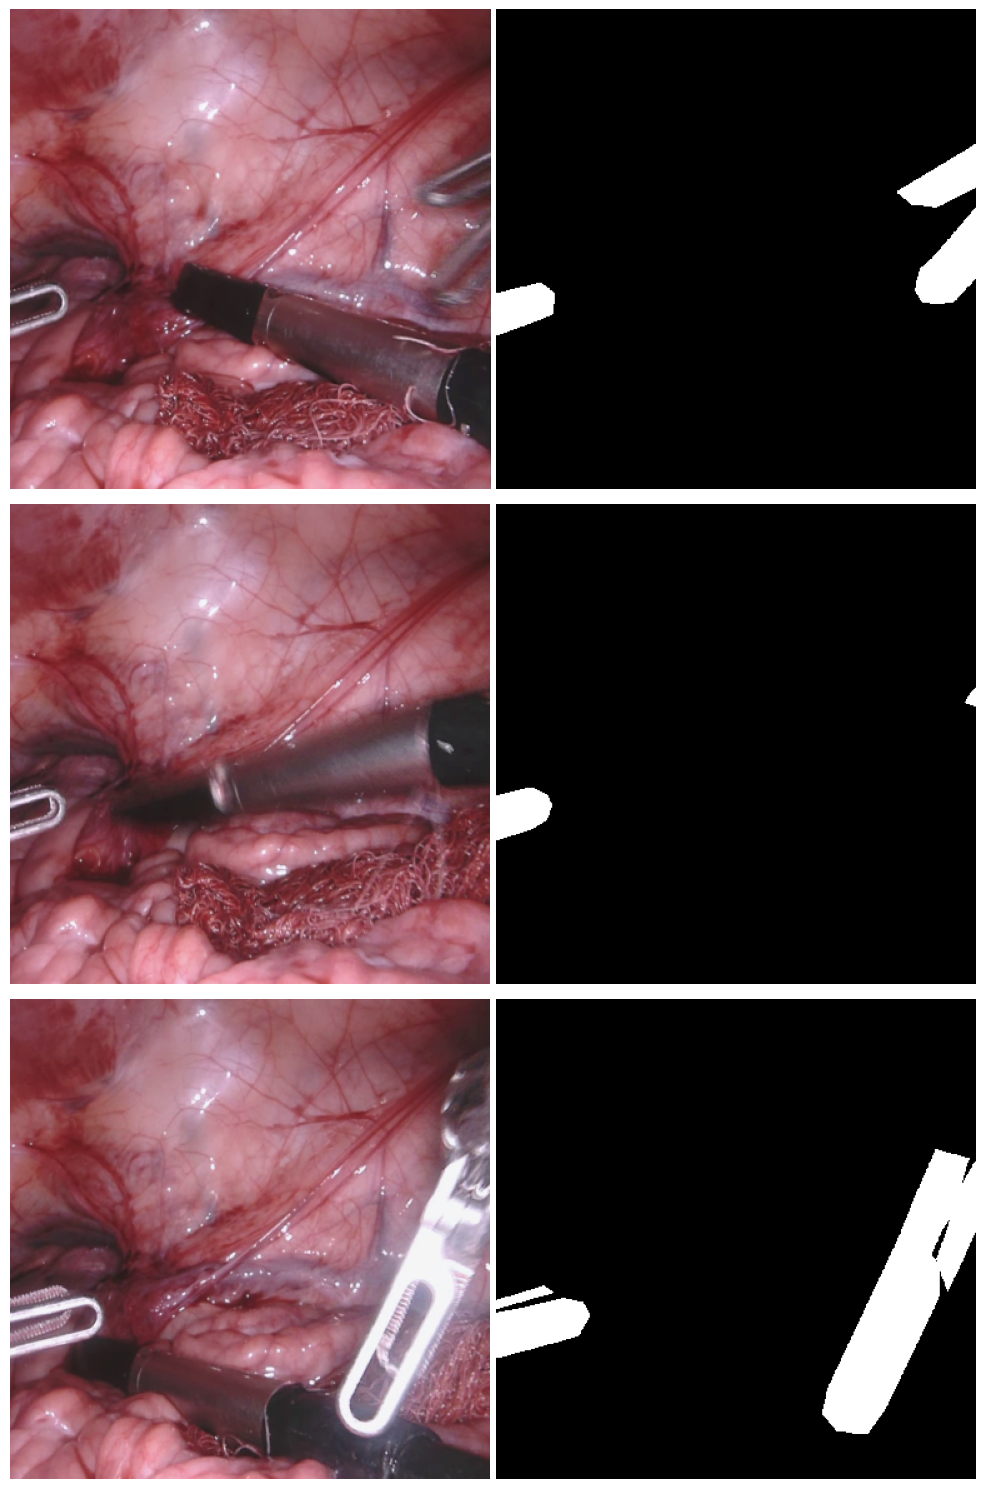

In [15]:
main_folder = Path("../../../data/endovis/endo17/data")

endo17_frames = main_folder / "frames" / "endo17_train_frames"
endo17_masks = main_folder / "masks" / "endo17_train_masks" / "part_masks"


dataset = InstrumentDataset(
    endo17_frames,
    endo17_masks,
    max_jump=5,
    subset=None,
    num_frames=8,
    max_num_obj=5,
    finetune=True,
)

plotDatasetSample(dataset, 3)

In [16]:
MAX_SKIP_VALUES = [10, 15, 5, 5]

increase_skip_fraction = [0.1, 0.3, 0.9, 100]


frames_folder = endo17_frames
masks_folder = endo17_masks

train_sampler, train_loader = renew_loader(
    frames_folder, masks_folder, 10, subset=None, finetune=False, max_num_obj=7
)

8 out of 8 videos accepted in ../../../data/endovis/endo17/data/frames/endo17_train_frames.


In [17]:
total_epoch = math.ceil(config["iterations"] / len(train_loader))
current_epoch = total_iter // len(train_loader)
print(f"Current epoch is {current_epoch}.")
print(f"We approximately use {total_epoch} epochs.")

change_skip_iter = [round(config["iterations"] * f) for f in increase_skip_fraction]
# Skip will only change after an epoch, not in the middle
print(
    f"The skip value will change approximately at the following iterations: {change_skip_iter[:-1]}"
)

Current epoch is 0.
We approximately use 2500 epochs.
The skip value will change approximately at the following iterations: [1000, 3000, 9000]


In [18]:
finetuning = False
# Need this to select random bases in different workers
np.random.seed(np.random.randint(2**30 - 1) + local_rank * 100)
try:
    pbar = tqdm(total=config["iterations"] + config["finetune"])
    while total_iter < config["iterations"] + config["finetune"]:
        # Crucial for randomness!
        train_sampler.set_epoch(current_epoch)
        current_epoch += 1
        pbar.update()
        pbar.set_description(f"Epoch {current_epoch}")

        # Train loop
        model.train()
        for data in train_loader:
            # Update skip if needed
            if stage != "0" and total_iter >= change_skip_iter[0]:
                while total_iter >= change_skip_iter[0]:
                    cur_skip = MAX_SKIP_VALUES[0]
                    max_skip_values = MAX_SKIP_VALUES[1:]
                    change_skip_iter = change_skip_iter[1:]
                print(f"Changing skip to {cur_skip=}")
                train_sampler, train_loader = renew_loader(
                    frames_folder,
                    masks_folder,
                    cur_skip,
                    subset=None,
                    finetune=False,
                    max_num_obj=7,
                )
                break

            # fine-tune means fewer augmentations to train the sensory memory
            if (
                config["finetune"] > 0
                and not finetuning
                and total_iter >= config["iterations"]
            ):
                train_sampler, train_loader = renew_loader(
                    frames_folder,
                    masks_folder,
                    cur_skip,
                    subset=None,
                    finetune=True,
                    max_num_obj=7,
                )
                finetuning = True
                model.save_network_interval = 50
                break

            model.do_pass(data, total_iter)
            total_iter += 1

            if total_iter >= config["iterations"] + config["finetune"]:
                break
    pbar.close()
finally:
    if not config["debug"] and model.logger is not None and total_iter > 5000:
        model.save_network(total_iter)
        model.save_checkpoint(total_iter)

Epoch 1:   0%|          | 1/10000 [00:00<00:00, 48770.98it/s]/home/nikhilhenry/projects/surgical_clean/SurgicalAI/external/XMem/model/trainer.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.config['amp']):
/home/nikhilhenry/projects/surgical_clean/SurgicalAI/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Epoch 4:   0%|          | 4/10000 [00:21<15:15:47,  5.50s/it]

KeyboardInterrupt: 

In [23]:
print("Training Completed")

Training Completed
